# Section A: EDA

### 1. Perform EDA and visualize trends in product sales and customer segments.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import ttest_ind,chi2_contingency
from prophet import Prophet
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
#loading data
accounts = pd.read_excel("Accounts view.xlsx")
portfolio = pd.read_excel("Portfolio view.xlsx")

### Account - Basic Data Overview

In [3]:
print("Shape:", accounts.shape)
print("Columns:", accounts.columns.tolist())
print("\nData Types:\n", accounts.dtypes)
print("\nMissing Values:\n", accounts.isnull().sum())
print("\nUnique Value Counts:\n", accounts.nunique())
print("\nBasic Statistics:\n", accounts.describe(include='number'))
print("\nCategorical Summary:\n", accounts.describe(include='object'))
print("\nSample Rows:\n", accounts.sample(5, random_state=42))
print("Duplicates in accounts:", accounts.duplicated().sum())
print("\nValue Counts per Column:")
for col in accounts.columns:
    print(f"\n{col}:\n", accounts[col].value_counts(dropna=False).head())

Shape: (3842, 9)
Columns: ['angaza_id', 'area', 'daily_price', 'upfront_price', 'expected_repayment_days', 'registration_date', 'free_days_included', 'product_group', 'country']

Data Types:
 angaza_id                  object
area                       object
daily_price                 int64
upfront_price               int64
expected_repayment_days     int64
registration_date          object
free_days_included          int64
product_group              object
country                    object
dtype: object

Missing Values:
 angaza_id                  0
area                       0
daily_price                0
upfront_price              0
expected_repayment_days    0
registration_date          0
free_days_included         0
product_group              0
country                    0
dtype: int64

Unique Value Counts:
 angaza_id                  3842
area                          2
daily_price                  14
upfront_price                26
expected_repayment_days      58
registration_

### Account - Cleaning Steps

In [4]:
accounts.columns[accounts.columns.str.contains(r'\s')] #checks for any whitespace anywhere in the name

Index([], dtype='object')

Account - Date/Time Checks

In [5]:
# Converting to proper datetime format
accounts['registration_date'] = pd.to_datetime(accounts['registration_date'], errors='coerce')

In [6]:
accounts = accounts[accounts['registration_date'].notna()]

print(" Cleaned accounts shape:", accounts.shape)
print(" Total nulls in registration_date:", accounts['registration_date'].isna().sum())

 Cleaned accounts shape: (3842, 9)
 Total nulls in registration_date: 0


In [7]:
accounts.head()

,angaza_id,area,daily_price,upfront_price,expected_repayment_days,registration_date,free_days_included,product_group,country
0,AC9403563,Area A,30,400,402,2023-01-12,3,Product 1,Kenya
1,AC9407464,Area B,80,1900,578,2023-02-12,3,Product 2,Kenya
2,AC9435050,Area A,30,400,402,2023-06-12,3,Product 1,Kenya
3,AC9437269,Area A,30,400,402,2023-07-12,3,Product 1,Kenya
4,AC9439351,Area A,30,400,402,2023-07-12,3,Product 1,Kenya


### Portfolio - Basic Dataset Overview

In [8]:
portfolio.sample(5)

,angaza_id,portfolio_date,days_to_cutoff,amount_toward_follow_on
61477,AC9558753,5/23/24,-9,0.0
644169,AC9749652,2/21/24,1,0.0
526877,AC9735546,1/29/24,3,75.0
202686,AC9408554,12/27/23,5,0.0
90602,AC9487200,2024-02-04 00:00:00,-2,0.0


In [9]:
print("Shape:", portfolio.shape)
print("Columns:", portfolio.columns.tolist())
print("\nData Types:\n", portfolio.dtypes)
print("\nMissing Values:\n", portfolio.isnull().sum())
print("\nUnique Value Counts:\n", portfolio.nunique())
print("\nBasic Statistics:\n", portfolio.describe(include='number'))
print("\nCategorical Summary:\n", portfolio.describe(include='object'))
print("\nSample Rows:\n", portfolio.sample(5, random_state=42))
print("Duplicates in portfolio:", portfolio.duplicated().sum())
print("\nValue Counts per Column:")
for col in portfolio.columns:
    print(f"\n{col}:\n", portfolio[col].value_counts(dropna=False).head())

Shape: (730728, 4)
Columns: ['angaza_id', 'portfolio_date', 'days_to_cutoff', 'amount_toward_follow_on']

Data Types:
 angaza_id                   object
portfolio_date              object
days_to_cutoff               int64
amount_toward_follow_on    float64
dtype: object

Missing Values:
 angaza_id                  0
portfolio_date             0
days_to_cutoff             0
amount_toward_follow_on    0
dtype: int64

Unique Value Counts:
 angaza_id                  3837
portfolio_date              239
days_to_cutoff              607
amount_toward_follow_on    1054
dtype: int64

Basic Statistics:
        days_to_cutoff  amount_toward_follow_on
count   730728.000000            730728.000000
mean         0.647558                27.541599
std         18.607972               107.219521
min       -228.000000                 0.000000
25%          0.000000                 0.000000
50%          1.000000                 0.000000
75%          4.000000                 0.000000
max        384.00000

### Portfolio - Cleaning Steps

In [10]:
portfolio.columns[portfolio.columns.str.contains(r'\s')] #checks for any whitespace

Index([], dtype='object')

In [11]:
portfolio['portfolio_date'] = pd.to_datetime(portfolio['portfolio_date'],errors='coerce') # Convert to proper date time format

In [12]:
from datetime import datetime

# Remove rows with invalid (NaT) dates
portfolio = portfolio[portfolio['portfolio_date'].notna()]

# Remove rows where portfolio_date is in the future
today = pd.to_datetime(datetime.today().date())
portfolio = portfolio[portfolio['portfolio_date'] <= today]

In [13]:
print("Cleaned portfolio shape:", portfolio.shape)
print("Null in portfolio_date:", portfolio['portfolio_date'].isna().sum())
print("Max portfolio_date:", portfolio['portfolio_date'].max())
print("Today:", today)

Cleaned portfolio shape: (730728, 4)
Null in portfolio_date: 0
Max portfolio_date: 2024-12-07 00:00:00
Today: 2025-07-23 00:00:00


### Portfolio Column (days_to_cutoff) cleanup

In [14]:
#checking negative rows
neg_cutoff_count = (portfolio['days_to_cutoff'] < 0).sum()
print("Negative cutoff values:", neg_cutoff_count)

Negative cutoff values: 160173


In [15]:
print("Unique cutoff values:", portfolio['days_to_cutoff'].nunique())
print("Top 10 most frequent cutoff values:")
print(portfolio['days_to_cutoff'].value_counts().head(10))

Unique cutoff values: 607
Top 10 most frequent cutoff values:
days_to_cutoff
 1    147994
 2     92887
 0     64745
 3     62127
 4     43605
 5     37992
-1     31621
 6     21173
-2     20228
 7     18177
Name: count, dtype: int64


In [16]:
print("Cutoff value stats:")
print(portfolio['days_to_cutoff'].describe())

Cutoff value stats:
count    730728.000000
mean          0.647558
std          18.607972
min        -228.000000
25%           0.000000
50%           1.000000
75%           4.000000
max         384.000000
Name: days_to_cutoff, dtype: float64


In [17]:
portfolio.drop(columns=['days_to_cutoff'], inplace=True, errors='ignore')

In [18]:
portfolio.head()

,angaza_id,portfolio_date,amount_toward_follow_on
0,AC9402087,2023-01-12,0.0
1,AC9402087,2023-02-12,0.0
2,AC9402087,2023-03-12,0.0
3,AC9411333,2023-03-12,210.0
4,AC9413399,2023-03-12,210.0


### Account - Distribution & Outliers

In [19]:
#initial check using IQR
# IQR-based outlier detection with percentage for each column
for col in accounts.select_dtypes(include='number'):
    q1, q3 = accounts[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = accounts[(accounts[col] < lower_bound) | (accounts[col] > upper_bound)][['angaza_id', col]]
    count = len(outliers)
    total = len(accounts)
    percentage = (count / total) * 100

    print("-" * 100)
    print(f"Column: {col}")
    print(f"Percentage of outliers: {percentage:.2f}%")

----------------------------------------------------------------------------------------------------
Column: daily_price
Percentage of outliers: 19.39%
----------------------------------------------------------------------------------------------------
Column: upfront_price
Percentage of outliers: 20.87%
----------------------------------------------------------------------------------------------------
Column: expected_repayment_days
Percentage of outliers: 9.71%
----------------------------------------------------------------------------------------------------
Column: free_days_included
Percentage of outliers: 0.00%


In [20]:
#Isolation Forest Method
iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

In [21]:
iso_features = accounts[['daily_price', 'upfront_price', 'expected_repayment_days']] #select features

In [22]:
iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42) #fit model
accounts['iso_outlier'] = iso.fit_predict(iso_features)

In [23]:
iso_outliers = accounts[accounts['iso_outlier'] == -1] # -1 = outlier, 1 = inlier

In [24]:
print(f"IsoForest: {len(iso_outliers)} outliers out of {len(accounts)} rows")

IsoForest: 39 outliers out of 3842 rows


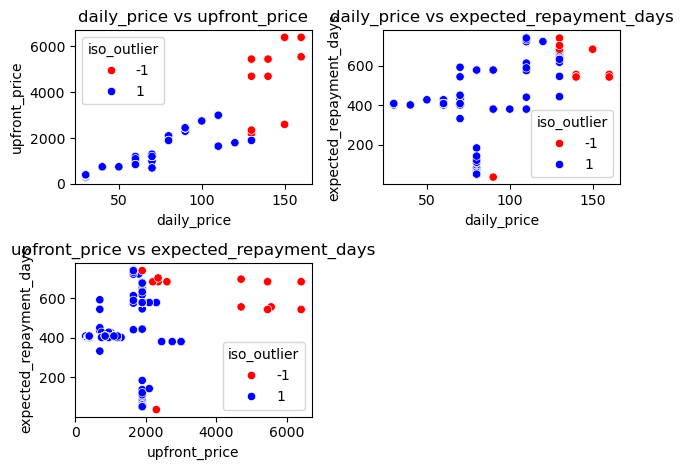

In [25]:
#visual check of outliers
# Plot 1: daily_price vs upfront_price
plt.subplot(2, 2, 1)
sns.scatterplot(data=accounts, x='daily_price', y='upfront_price', hue='iso_outlier', palette={1: "blue", -1: "red"})
plt.title("daily_price vs upfront_price")

# Plot 2: daily_price vs expected_repayment_days
plt.subplot(2, 2, 2)
sns.scatterplot(data=accounts, x='daily_price', y='expected_repayment_days', hue='iso_outlier', palette={1: "blue", -1: "red"})
plt.title("daily_price vs expected_repayment_days")

# Plot 3: upfront_price vs expected_repayment_days
plt.subplot(2, 2, 3)
sns.scatterplot(data=accounts, x='upfront_price', y='expected_repayment_days', hue='iso_outlier', palette={1: "blue", -1: "red"})
plt.title("upfront_price vs expected_repayment_days")

plt.tight_layout()
plt.show()

In [26]:
accounts.columns

Index(['angaza_id', 'area', 'daily_price', 'upfront_price',
       'expected_repayment_days', 'registration_date', 'free_days_included',
       'product_group', 'country', 'iso_outlier'],
      dtype='object')

In [27]:
import shap
explainer = shap.Explainer(iso, iso_features)
shap_values = explainer(iso_features)

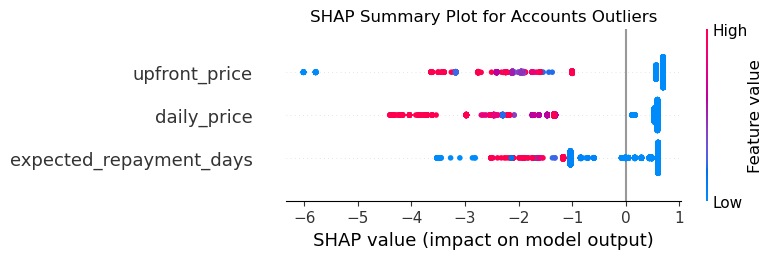

In [28]:
shap.plots.beeswarm(shap_values, show=False)
plt.title("SHAP Summary Plot for Accounts Outliers")
plt.tight_layout()
plt.show()

### Portfolio - Distribution & Outliers

In [29]:
#initial check using IQR
# IQR-based outlier detection with percentage for each column
for col in portfolio.select_dtypes(include='number'):
    q1, q3 = portfolio[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = portfolio[(portfolio[col] < lower_bound) | (portfolio[col] > upper_bound)][['angaza_id', col]]
    count = len(outliers)
    total = len(portfolio)
    percentage = (count / total) * 100

    print("-" * 100)
    print(f"Column: {col}")
    print(f"Percentage of outliers: {percentage:.2f}%")

----------------------------------------------------------------------------------------------------
Column: amount_toward_follow_on
Percentage of outliers: 23.97%


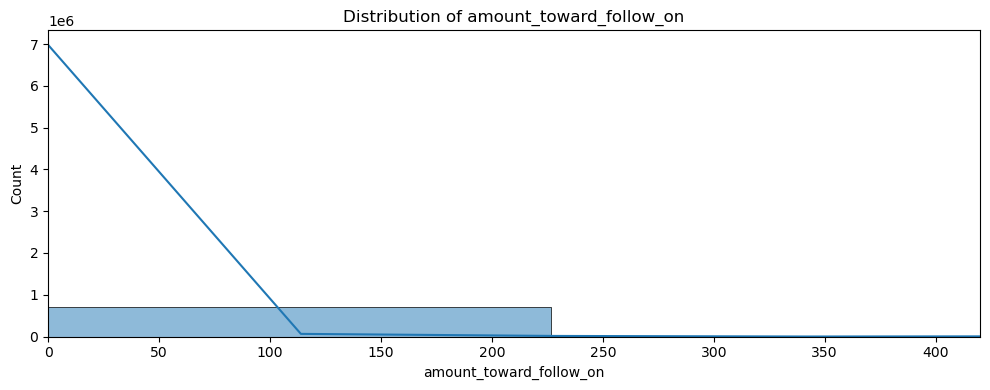

In [30]:
plt.figure(figsize=(10, 4))
sns.histplot(portfolio[col], bins=100, kde=True)
plt.title(f"Distribution of {col}")
plt.xlim(0, portfolio[col].quantile(0.99))
plt.tight_layout()
plt.show()

In [31]:
top_customers = outliers['angaza_id'].value_counts().head()
print("\nTop Customers with Outliers:")
print(top_customers)


Top Customers with Outliers:
angaza_id
AC9398682    211
AC9431322    199
AC9491031    190
AC9453833    189
AC9454774    188
Name: count, dtype: int64


In [32]:
portfolio['iqr_outlier'] = 0

# Mark outliers using IQR
for col in portfolio.select_dtypes(include='number'):
    q1, q3 = portfolio[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    is_outlier = (portfolio[col] < lower_bound) | (portfolio[col] > upper_bound)
    portfolio.loc[is_outlier, 'iqr_outlier'] = 1  # mark as outlier

In [33]:
portfolio.head()

,angaza_id,portfolio_date,amount_toward_follow_on,iqr_outlier
0,AC9402087,2023-01-12,0.0,0
1,AC9402087,2023-02-12,0.0,0
2,AC9402087,2023-03-12,0.0,0
3,AC9411333,2023-03-12,210.0,1
4,AC9413399,2023-03-12,210.0,1


### EDA Visualisations for product/customer/sales

### Univariate Analysis

<Axes: title={'center': 'Weekly Product Sales'}, xlabel='registration_date'>

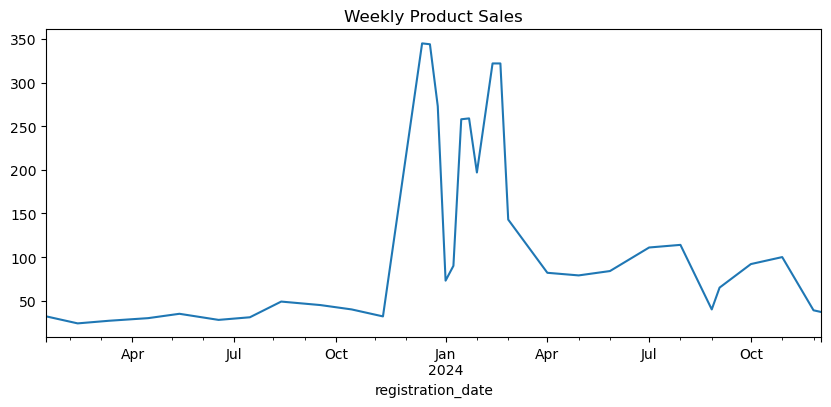

In [34]:
# Product Sales Plot (Time Series)
sales_trend = accounts.groupby(accounts['registration_date'].dt.to_period('W'))['angaza_id'].count()
sales_trend.plot(title="Weekly Product Sales", figsize=(10, 4))

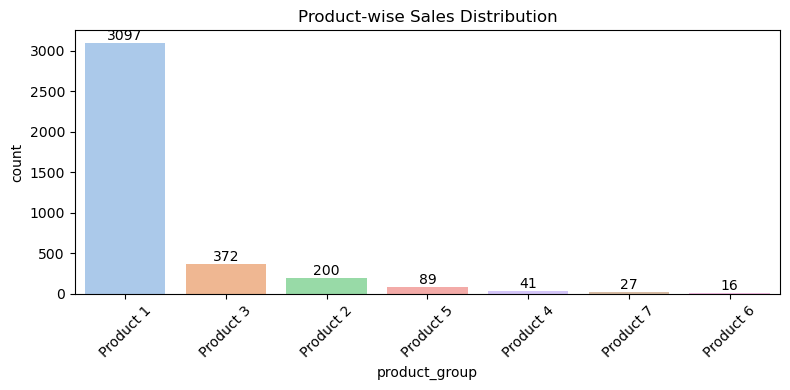

In [35]:
# Product count by category in accounts table
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
ax = sns.countplot(data=accounts, x='product_group', order=accounts['product_group'].value_counts().index, palette='pastel')
plt.xticks(rotation=45)
plt.title("Product-wise Sales Distribution")

for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), int(bar.get_height()), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

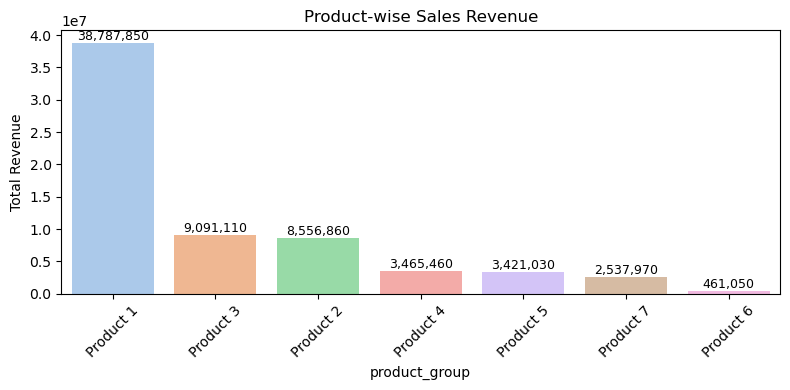

In [36]:
# based on assumption created a total_price formula from available columns
accounts['total_price'] = accounts['upfront_price'] + (accounts['daily_price'] * accounts['expected_repayment_days'])
sales_value = accounts.groupby('product_group')['total_price'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
ax = sns.barplot(x=sales_value.index, y=sales_value.values, palette='pastel')
plt.title("Product-wise Sales Revenue")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{int(bar.get_height()):,}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

### 2. Analyze sales patterns across Area A and B. Suggest hypotheses explaining differences using statistical tests (e.g., t-test, chi-square).

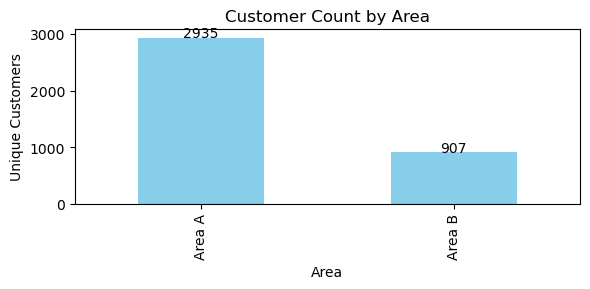

In [37]:
area_counts = accounts.groupby('area')['angaza_id'].nunique()

ax = area_counts.plot(kind='bar', figsize=(6,3), color='skyblue', title='Customer Count by Area')
for bar in ax.containers[0]:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, int(bar.get_height()), ha='center')
plt.ylabel("Unique Customers")
plt.xlabel("Area")
plt.tight_layout()
plt.show()

### Area A vs B – Sales & Repayment Comparison using Statistical Methods

In [38]:
area_a = accounts[accounts['area'] == 'Area A']
area_b = accounts[accounts['area'] == 'Area B']

In [39]:
# T-test to statistically test if average upfront payments differ between the two areas
t_stat, p_val = ttest_ind(area_a['upfront_price'], area_b['upfront_price'], nan_policy='omit')
print(f"T-test on Upfront Price: t={t_stat:.3f}, p={p_val:.6f}")

T-test on Upfront Price: t=-13.337, p=0.000000


In [40]:
# Chi-Square test to compare product preferences by area
product_area = pd.crosstab(accounts['area'], accounts['product_group'])
chi2, p, dof, expected = chi2_contingency(product_area)
print(f"Chi-Square test: chi2={chi2:.3f}, p={p:.6f}")

Chi-Square test: chi2=277.315, p=0.000000


### 3. Detect anomalies or customers likely to churn using unsupervised techniques.

### Dataset creation

### 1.

In [41]:
# Merge on angaza_id
merged_df = pd.merge(portfolio, accounts, on="angaza_id", how="left")

In [42]:
# Calculate unit_age_days
merged_df["unit_age_days"] = (
    (merged_df["portfolio_date"] - merged_df["registration_date"]).dt.days
    - merged_df["free_days_included"]
)

In [43]:
# Reset index and inspect
merged_df.reset_index(drop=True, inplace=True)

In [44]:
# Drop rows where unit_age_days < 0 or portfolio_date in the future, as customer cant buy product before even getting registered
today = pd.Timestamp.today().normalize()
merged_df = merged_df[
    (merged_df["unit_age_days"] >= 0) &
    (merged_df["portfolio_date"] <= today)
]

In [45]:
merged_df["expected_payment"] = merged_df["daily_price"]

In [46]:
merged_df.head()

,angaza_id,portfolio_date,amount_toward_follow_on,iqr_outlier,area,daily_price,upfront_price,expected_repayment_days,registration_date,free_days_included,product_group,country,iso_outlier,total_price,unit_age_days,expected_payment
1,AC9402087,2023-02-12,0.000000,0,Area B,80,1900,578,2023-01-12,3,Product 2,Kenya,1,48140,28,80
2,AC9402087,2023-03-12,0.000000,0,Area B,80,1900,578,2023-01-12,3,Product 2,Kenya,1,48140,56,80
6,AC9411333,2023-04-12,0.000000,0,Area A,30,400,402,2023-03-12,3,Product 1,Kenya,1,12460,28,30
7,AC9402087,2023-04-12,1066.666667,1,Area B,80,1900,578,2023-01-12,3,Product 2,Kenya,1,48140,87,80
8,AC9413399,2023-04-12,0.000000,0,Area A,30,400,402,2023-03-12,3,Product 1,Kenya,1,12460,28,30


### 2.

In [47]:
repayment_summary = merged_df.groupby('angaza_id').agg(
    total_paid=('amount_toward_follow_on', 'sum'),
    total_expected=('expected_payment', 'sum'),
    num_payment_days=('portfolio_date', 'count')
).reset_index()

In [48]:
repayment_summary['repayment_ratio'] = repayment_summary['total_paid'] / repayment_summary['total_expected']
repayment_summary.fillna(0, inplace=True)

### 3.

In [49]:
final_merged = pd.merge(
    merged_df.drop(columns=['days_to_cutoff'], errors='ignore'),  # Drop unreliable column
    merged_df[['angaza_id', 'portfolio_date', 'daily_price', 'expected_repayment_days']],
    on=['angaza_id', 'portfolio_date'],
    how='left'
)

In [50]:
final_merged['daily_price'] = final_merged['daily_price_y']
final_merged['expected_repayment_days'] = final_merged['expected_repayment_days_y']

In [51]:
final_merged.head()

,angaza_id,portfolio_date,amount_toward_follow_on,iqr_outlier,area,daily_price_x,upfront_price,expected_repayment_days_x,registration_date,free_days_included,product_group,country,iso_outlier,total_price,unit_age_days,expected_payment,daily_price_y,expected_repayment_days_y,daily_price,expected_repayment_days
0,AC9402087,2023-02-12,0.000000,0,Area B,80,1900,578,2023-01-12,3,Product 2,Kenya,1,48140,28,80,80,578,80,578
1,AC9402087,2023-03-12,0.000000,0,Area B,80,1900,578,2023-01-12,3,Product 2,Kenya,1,48140,56,80,80,578,80,578
2,AC9411333,2023-04-12,0.000000,0,Area A,30,400,402,2023-03-12,3,Product 1,Kenya,1,12460,28,30,30,402,30,402
3,AC9402087,2023-04-12,1066.666667,1,Area B,80,1900,578,2023-01-12,3,Product 2,Kenya,1,48140,87,80,80,578,80,578
4,AC9413399,2023-04-12,0.000000,0,Area A,30,400,402,2023-03-12,3,Product 1,Kenya,1,12460,28,30,30,402,30,402


In [52]:
final_merged.drop(columns=['daily_price_x', 'daily_price_y',
                           'expected_repayment_days_x', 'expected_repayment_days_y'],
                  inplace=True)

In [53]:
final_merged.head()

,angaza_id,portfolio_date,amount_toward_follow_on,iqr_outlier,area,upfront_price,registration_date,free_days_included,product_group,country,iso_outlier,total_price,unit_age_days,expected_payment,daily_price,expected_repayment_days
0,AC9402087,2023-02-12,0.000000,0,Area B,1900,2023-01-12,3,Product 2,Kenya,1,48140,28,80,80,578
1,AC9402087,2023-03-12,0.000000,0,Area B,1900,2023-01-12,3,Product 2,Kenya,1,48140,56,80,80,578
2,AC9411333,2023-04-12,0.000000,0,Area A,400,2023-03-12,3,Product 1,Kenya,1,12460,28,30,30,402
3,AC9402087,2023-04-12,1066.666667,1,Area B,1900,2023-01-12,3,Product 2,Kenya,1,48140,87,80,80,578
4,AC9413399,2023-04-12,0.000000,0,Area A,400,2023-03-12,3,Product 1,Kenya,1,12460,28,30,30,402


### Churn Detection using Unsupervised Learning

### KMeans Clustering

In [54]:
X = repayment_summary[['repayment_ratio', 'total_paid', 'num_payment_days']]
X_scaled = StandardScaler().fit_transform(X)

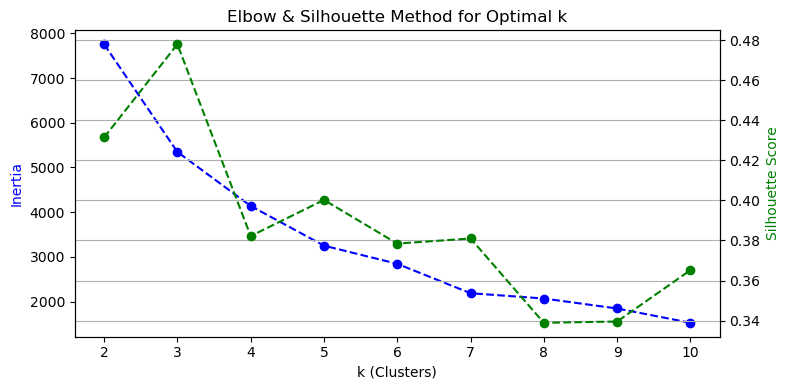

In [55]:
# Elbow Method to Choose k value
from sklearn.metrics import silhouette_score

sil_scores = []
inertias = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))
    inertias.append(km.inertia_)

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()

ax1.plot(K, inertias, 'b--o', label='Inertia')
ax2.plot(K, sil_scores, 'g--o', label='Silhouette')

ax1.set_xlabel('k (Clusters)')
ax1.set_ylabel('Inertia', color='b')
ax2.set_ylabel('Silhouette Score', color='g')
plt.title('Elbow & Silhouette Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()

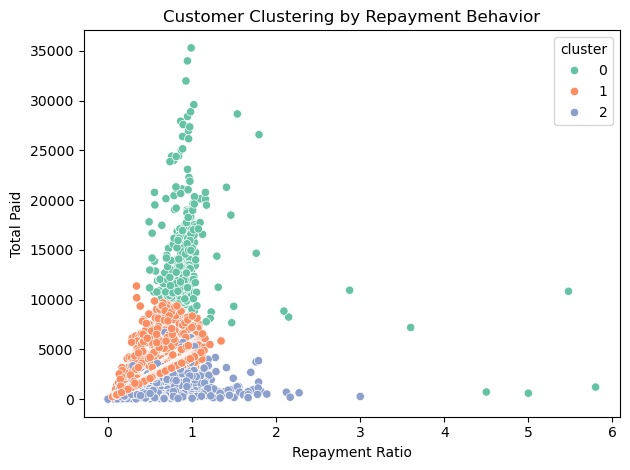

In [56]:
kmeans = KMeans(n_clusters=3, random_state=0)
repayment_summary['cluster'] = kmeans.fit_predict(X_scaled)
sns.scatterplot(data=repayment_summary, x='repayment_ratio', y='total_paid', hue='cluster', palette='Set2')
plt.title("Customer Clustering by Repayment Behavior")
plt.xlabel("Repayment Ratio")
plt.ylabel("Total Paid")
plt.tight_layout()
plt.show()

In [57]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
sil_score = silhouette_score(X_scaled, repayment_summary['cluster'])
print(f"Silhouette Score for k=3: {sil_score:.4f}")

Silhouette Score for k=3: 0.4780


# Section B: Collection Performance Metrics

### Feature Engineering for Collection

In [58]:
# for several metrics used within Sun King 

In [59]:
final_merged.columns

Index(['angaza_id', 'portfolio_date', 'amount_toward_follow_on', 'iqr_outlier',
       'area', 'upfront_price', 'registration_date', 'free_days_included',
       'product_group', 'country', 'iso_outlier', 'total_price',
       'unit_age_days', 'expected_payment', 'daily_price',
       'expected_repayment_days'],
      dtype='object')

In [60]:
# 1. Unit Age Weeks (rounded down to nearest int)
final_merged['unit_age_weeks'] = (final_merged['unit_age_days'] // 7).astype(int)

In [61]:
# 2. Unit Proportional Age (UPA): unit_age_days / expected_repayment_days → rounded to 1 decimal
final_merged['unit_proportional_age'] = (final_merged['unit_age_days'] / final_merged['expected_repayment_days']).round(1)

In [62]:
# 3. Status: ENABLED if amount paid > 0, else DISABLED
final_merged['status'] = np.where(final_merged['amount_toward_follow_on'] > 0, 'ENABLED', 'DISABLED')

In [63]:
final_merged.head()

,angaza_id,portfolio_date,amount_toward_follow_on,iqr_outlier,area,upfront_price,registration_date,free_days_included,product_group,country,iso_outlier,total_price,unit_age_days,expected_payment,daily_price,expected_repayment_days,unit_age_weeks,unit_proportional_age,status
0,AC9402087,2023-02-12,0.000000,0,Area B,1900,2023-01-12,3,Product 2,Kenya,1,48140,28,80,80,578,4,0.0,DISABLED
1,AC9402087,2023-03-12,0.000000,0,Area B,1900,2023-01-12,3,Product 2,Kenya,1,48140,56,80,80,578,8,0.1,DISABLED
2,AC9411333,2023-04-12,0.000000,0,Area A,400,2023-03-12,3,Product 1,Kenya,1,12460,28,30,30,402,4,0.1,DISABLED
3,AC9402087,2023-04-12,1066.666667,1,Area B,1900,2023-01-12,3,Product 2,Kenya,1,48140,87,80,80,578,12,0.2,ENABLED
4,AC9413399,2023-04-12,0.000000,0,Area A,400,2023-03-12,3,Product 1,Kenya,1,12460,28,30,30,402,4,0.1,DISABLED


In [64]:
# 1. Disabled rates across portfolio date
# Daily disabled rate = unique disabled accounts / total unique accounts on that day
disabled_rate_daily = (
    final_merged.groupby('portfolio_date')
    .agg(disabled_count=('status', lambda x: x[x == 'DISABLED'].nunique()),
         total_accounts=('angaza_id', 'nunique'))
    .assign(disabled_rate_date=lambda x: x['disabled_count'] / x['total_accounts'])
    .reset_index()
)[['portfolio_date', 'disabled_rate_date']]

In [65]:
# Display the first few records
print(disabled_rate_daily.head())

  portfolio_date  disabled_rate_date
0     2023-02-12            0.031250
1     2023-03-12            0.017857
2     2023-04-12            0.012048
3     2023-05-12            0.008850
4     2023-06-12            0.006757


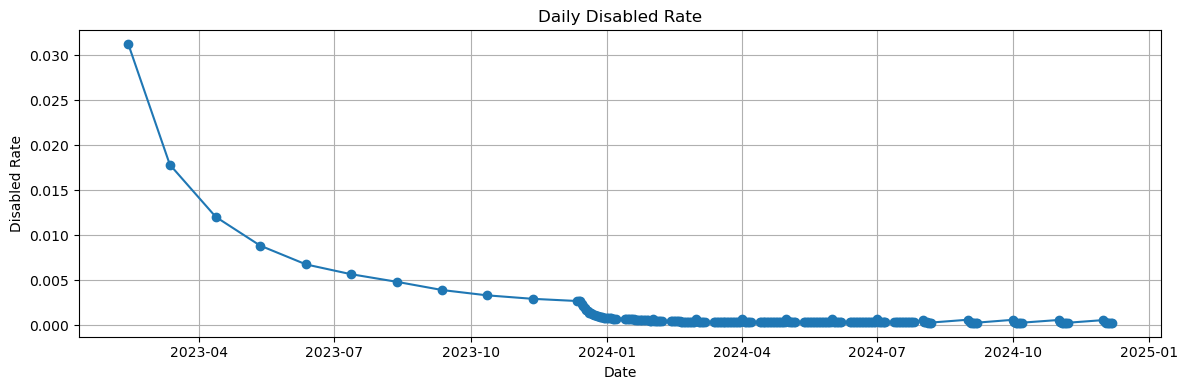

In [66]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(disabled_rate_daily['portfolio_date'], disabled_rate_daily['disabled_rate_date'], marker='o')
plt.title('Daily Disabled Rate')
plt.xlabel('Date')
plt.ylabel('Disabled Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
# 2. Repayment speed across portfolio date
repayment_speed_daily = (
    final_merged.groupby('portfolio_date')
    .agg(total_collected=('amount_toward_follow_on', 'sum'),
         total_expected=('expected_payment', 'sum'))
    .assign(repayment_speed_date=lambda x: x['total_collected'] / x['total_expected'])
    .reset_index()
)[['portfolio_date', 'repayment_speed_date']]

In [68]:
print(repayment_speed_daily.head())

  portfolio_date  repayment_speed_date
0     2023-02-12              0.804795
1     2023-03-12              0.477143
2     2023-04-12              0.908430
3     2023-05-12              1.045301
4     2023-06-12              0.421126


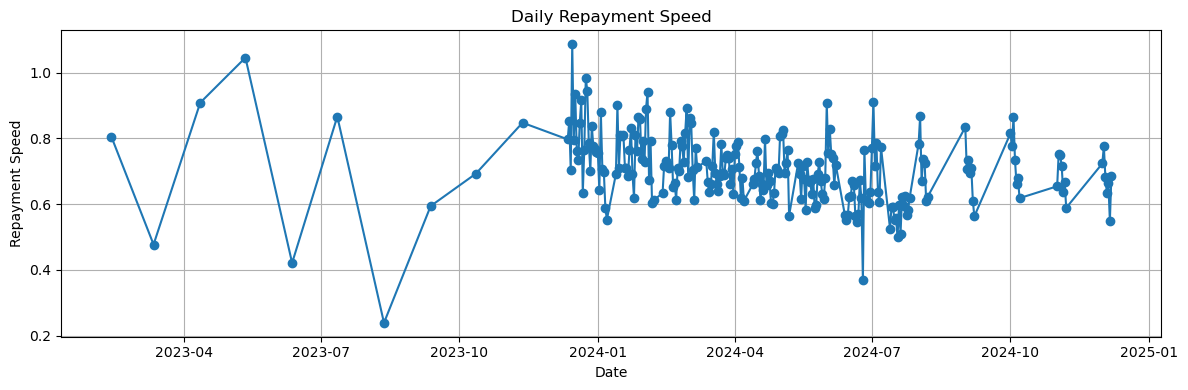

In [69]:
plt.figure(figsize=(12, 4))
plt.plot(repayment_speed_daily['portfolio_date'], repayment_speed_daily['repayment_speed_date'], marker='o')
plt.title('Daily Repayment Speed')
plt.xlabel('Date')
plt.ylabel('Repayment Speed')
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
# 3. Disabled rates across portfolio week
# Get start of the week
final_merged['portfolio_week'] = final_merged['portfolio_date'] - pd.to_timedelta(final_merged['portfolio_date'].dt.weekday, unit='d')

# Count ENABLED & DISABLED days per customer per week
status_by_week = (
    final_merged.groupby(['portfolio_week', 'angaza_id'])
    .agg(disabled_days=('status', lambda x: (x == 'DISABLED').sum()),
         total_days=('status', 'count'))
    .reset_index()
)

# Compute total disabled unit-days / total unit-days across all accounts
weekly_disabled_rate = (
    status_by_week.groupby('portfolio_week')
    .agg(disabled_unit_days=('disabled_days', 'sum'),
         total_unit_days=('total_days', 'sum'))
    .assign(disabled_rate_week=lambda x: x['disabled_unit_days'] / x['total_unit_days'])
    .reset_index()
)[['portfolio_week', 'disabled_rate_week']]

In [71]:
print(weekly_disabled_rate.head())

  portfolio_week  disabled_rate_week
0     2023-02-06            0.843750
1     2023-03-06            0.910714
2     2023-04-10            0.843373
3     2023-05-08            0.876106
4     2023-06-12            0.891892


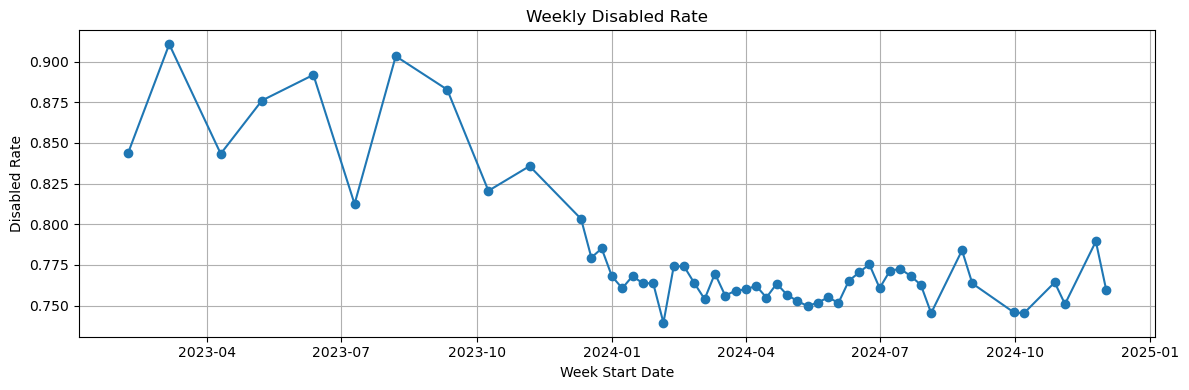

In [72]:
plt.figure(figsize=(12, 4))
plt.plot(weekly_disabled_rate['portfolio_week'], weekly_disabled_rate['disabled_rate_week'], marker='o')
plt.title('Weekly Disabled Rate')
plt.xlabel('Week Start Date')
plt.ylabel('Disabled Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
# 4.Repayment speed across portfolio week

In [74]:
repayment_speed_weekly = (
    final_merged.groupby('portfolio_week')
    .agg(total_collected=('amount_toward_follow_on', 'sum'),
         total_expected=('expected_payment', 'sum'))
    .assign(repayment_speed_week=lambda x: x['total_collected'] / x['total_expected'])
    .reset_index()
)[['portfolio_week', 'repayment_speed_week']]

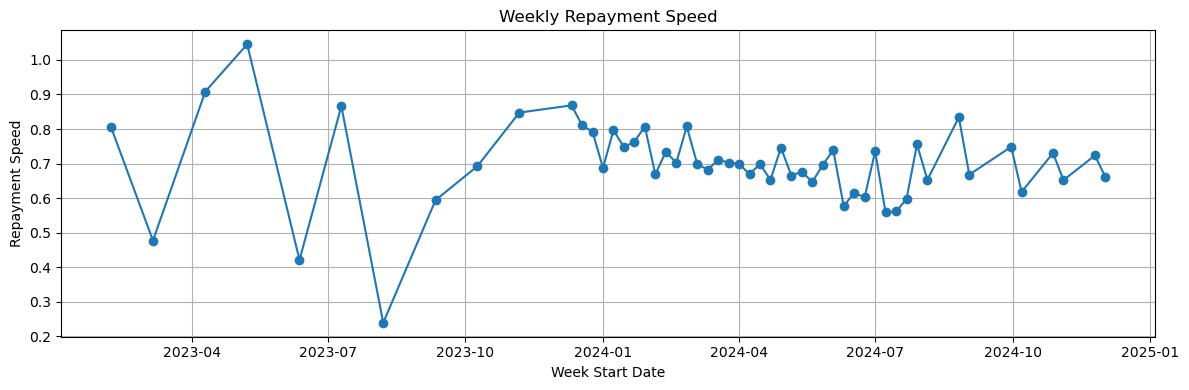

In [75]:
plt.figure(figsize=(12, 4))
plt.plot(repayment_speed_weekly['portfolio_week'], repayment_speed_weekly['repayment_speed_week'], marker='o')
plt.title('Weekly Repayment Speed')
plt.xlabel('Week Start Date')
plt.ylabel('Repayment Speed')
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
print(repayment_speed_weekly.head())

  portfolio_week  repayment_speed_week
0     2023-02-06              0.804795
1     2023-03-06              0.477143
2     2023-04-10              0.908430
3     2023-05-08              1.045301
4     2023-06-12              0.421126


In [77]:
final_merged.head()

,angaza_id,portfolio_date,amount_toward_follow_on,iqr_outlier,area,upfront_price,registration_date,free_days_included,product_group,country,iso_outlier,total_price,unit_age_days,expected_payment,daily_price,expected_repayment_days,unit_age_weeks,unit_proportional_age,status,portfolio_week
0,AC9402087,2023-02-12,0.000000,0,Area B,1900,2023-01-12,3,Product 2,Kenya,1,48140,28,80,80,578,4,0.0,DISABLED,2023-02-06
1,AC9402087,2023-03-12,0.000000,0,Area B,1900,2023-01-12,3,Product 2,Kenya,1,48140,56,80,80,578,8,0.1,DISABLED,2023-03-06
2,AC9411333,2023-04-12,0.000000,0,Area A,400,2023-03-12,3,Product 1,Kenya,1,12460,28,30,30,402,4,0.1,DISABLED,2023-04-10
3,AC9402087,2023-04-12,1066.666667,1,Area B,1900,2023-01-12,3,Product 2,Kenya,1,48140,87,80,80,578,12,0.2,ENABLED,2023-04-10
4,AC9413399,2023-04-12,0.000000,0,Area A,400,2023-03-12,3,Product 1,Kenya,1,12460,28,30,30,402,4,0.1,DISABLED,2023-04-10


In [78]:
final_merged.columns

Index(['angaza_id', 'portfolio_date', 'amount_toward_follow_on', 'iqr_outlier',
       'area', 'upfront_price', 'registration_date', 'free_days_included',
       'product_group', 'country', 'iso_outlier', 'total_price',
       'unit_age_days', 'expected_payment', 'daily_price',
       'expected_repayment_days', 'unit_age_weeks', 'unit_proportional_age',
       'status', 'portfolio_week'],
      dtype='object')

### Forecasting using Prophet

In [79]:
disabled_rate_daily_prophet = disabled_rate_daily.rename(columns={
    'portfolio_date': 'ds',
    'disabled_rate_date': 'y'
})

In [80]:
# Instantiate and fit model
model_disabled = Prophet()
model_disabled.fit(disabled_rate_daily_prophet)

01:07:47 - cmdstanpy - INFO - Chain [1] start processing
01:07:47 - cmdstanpy - INFO - Chain [1] done processing


In [81]:
future_disabled = model_disabled.make_future_dataframe(periods=30)
forecast_disabled = model_disabled.predict(future_disabled)

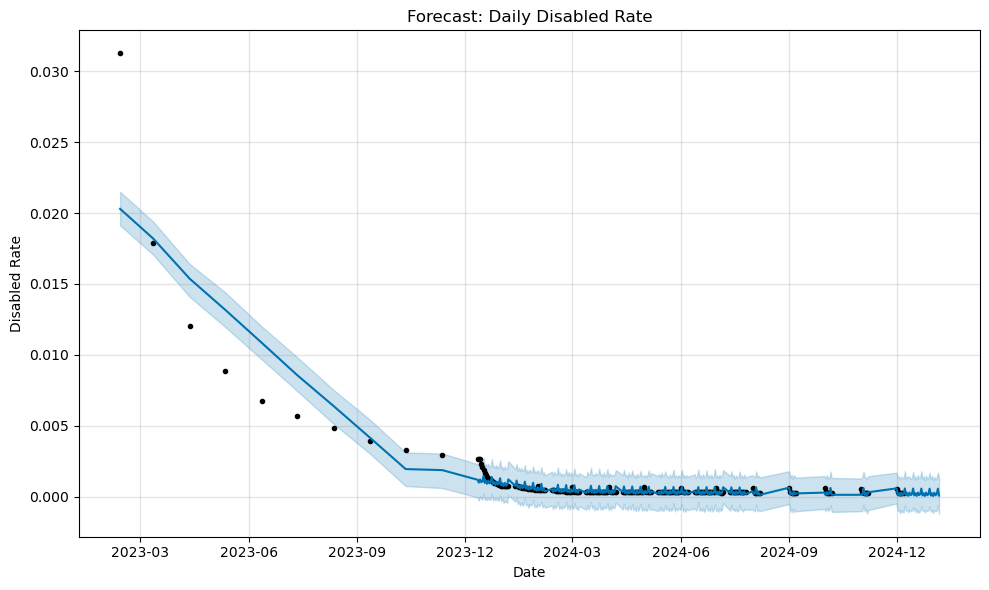

In [82]:
model_disabled.plot(forecast_disabled)
plt.title("Forecast: Daily Disabled Rate")
plt.xlabel("Date")
plt.ylabel("Disabled Rate")
plt.tight_layout()
plt.show()

In [83]:
repayment_speed_daily_prophet = repayment_speed_daily.rename(columns={
    'portfolio_date': 'ds',
    'repayment_speed_date': 'y'
})

In [84]:
model_repayment = Prophet()
model_repayment.fit(repayment_speed_daily_prophet)

01:07:48 - cmdstanpy - INFO - Chain [1] start processing
01:07:48 - cmdstanpy - INFO - Chain [1] done processing


In [85]:
future_repay = model_repayment.make_future_dataframe(periods=30)
forecast_repay = model_repayment.predict(future_repay)

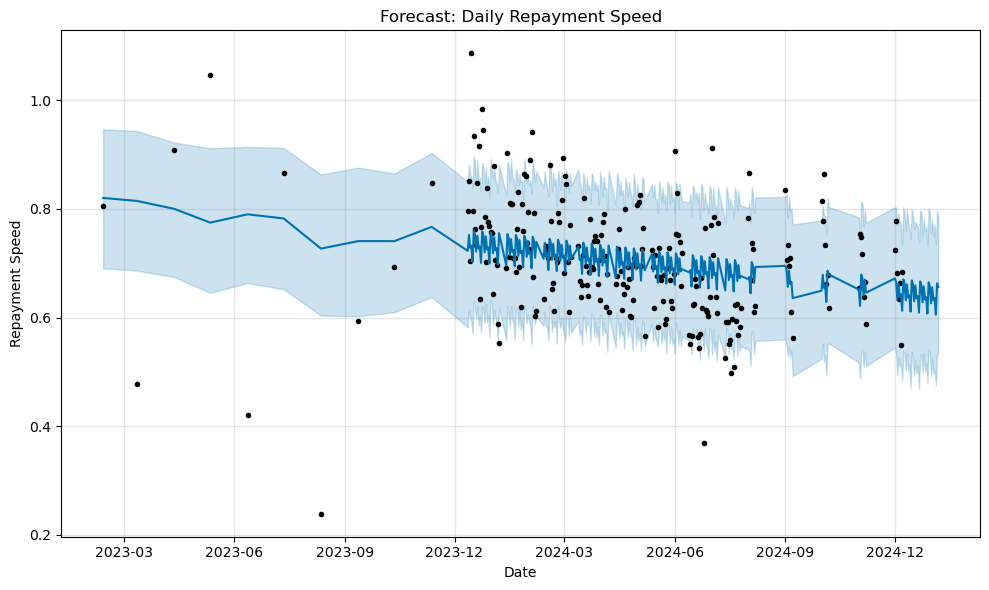

In [86]:
model_repayment.plot(forecast_repay)
plt.title("Forecast: Daily Repayment Speed")
plt.xlabel("Date")
plt.ylabel("Repayment Speed")
plt.tight_layout()
plt.show()

In [87]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [88]:
customer_features = (
    final_merged.groupby('angaza_id')
    .agg(
        avg_repayment=('amount_toward_follow_on', 'mean'),
        total_repayment=('amount_toward_follow_on', 'sum'),
        avg_unit_age=('unit_age_days', 'mean'),
        avg_daily_price=('daily_price', 'mean'),
        avg_expected_days=('expected_repayment_days', 'mean'),
        avg_upa=('unit_proportional_age', 'mean'),
        disable_rate=('status', lambda x: (x == 'DISABLED').mean())
    )
    .fillna(0)
)

In [89]:
# Step 2: Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_features)

In [90]:
# Apply KMeans clustering 
kmeans = KMeans(n_clusters=3, random_state=42)
customer_features['cluster'] = kmeans.fit_predict(X_scaled)

In [91]:
cluster_map = (
    customer_features.groupby('cluster')['total_repayment']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
cluster_map['segment'] = ['Good', 'Borderline', 'Risky']

In [92]:
segment_dict = dict(zip(cluster_map['cluster'], cluster_map['segment']))
customer_features['segment'] = customer_features['cluster'].map(segment_dict)

In [93]:
customer_clusters = customer_features.reset_index()[['angaza_id', 'segment']]
print(customer_clusters.head())

    angaza_id segment
0  AC10000403   Risky
1  AC10000442    Good
2  AC10000614   Risky
3  AC10000761   Risky
4  AC10000825   Risky


In [94]:
from sklearn.decomposition import PCA

In [95]:
# Reduce features to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [96]:
plot_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
plot_df['segment'] = customer_features['segment'].values

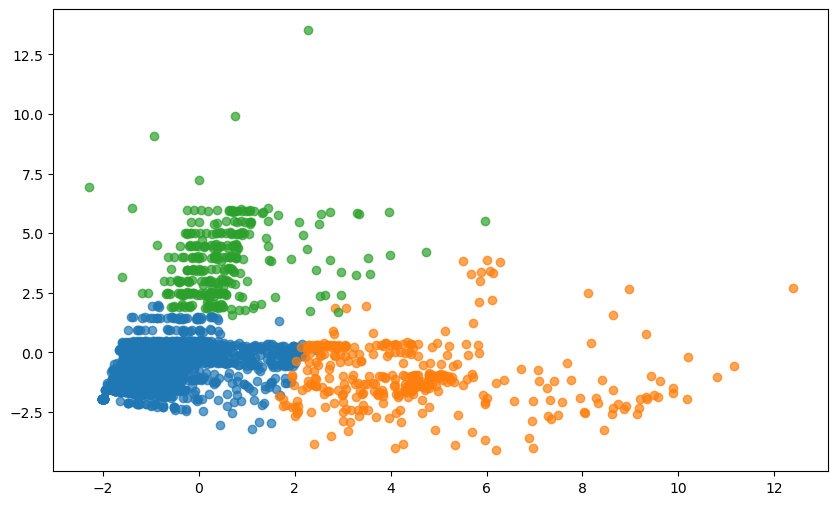

In [97]:
plt.figure(figsize=(10, 6))
for label in plot_df['segment'].unique():
    subset = plot_df[plot_df['segment'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label, alpha=0.7)

plt.show()    

# Thank you!